In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Electronics_train.csv')

In [3]:
data.head()

,Unnamed: 0,BP,blue,c_speed,dual,front_c,4G,m_int,m_dep,m_wt,...,px_h,px_w,ram,sc_h,sc_w,talk_t,3G,ts,wifi,target
0,0,842,0,2.2,0,1,0,7,0.6,188,...,20,756,2549,9,7,19,0,0,1,1
1,1,1021,1,0.5,1,0,1,53,0.7,136,...,905,1988,2631,17,3,7,1,1,0,2
2,2,563,1,0.5,1,2,1,41,0.9,145,...,1263,1716,2603,11,2,9,1,1,0,2
3,3,615,1,2.5,0,0,0,10,0.8,131,...,1216,1786,2769,16,8,11,1,0,0,2
4,4,1821,1,1.2,0,13,1,44,0.6,141,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
data = data.iloc[:,1:]

In [5]:
data['target'].value_counts()

3    379
0    375
2    374
1    372
Name: target, dtype: int64

In [6]:
data.info() #결측값 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BP       1500 non-null   int64  
 1   blue     1500 non-null   int64  
 2   c_speed  1500 non-null   float64
 3   dual     1500 non-null   int64  
 4   front_c  1500 non-null   int64  
 5   4G       1500 non-null   int64  
 6   m_int    1500 non-null   int64  
 7   m_dep    1500 non-null   float64
 8   m_wt     1500 non-null   int64  
 9   n_cores  1500 non-null   int64  
 10  prim_c   1500 non-null   int64  
 11  px_h     1500 non-null   int64  
 12  px_w     1500 non-null   int64  
 13  ram      1500 non-null   int64  
 14  sc_h     1500 non-null   int64  
 15  sc_w     1500 non-null   int64  
 16  talk_t   1500 non-null   int64  
 17  3G       1500 non-null   int64  
 18  ts       1500 non-null   int64  
 19  wifi     1500 non-null   int64  
 20  target   1500 non-null   int64  
dtypes: float64(2),

In [7]:
X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=30)

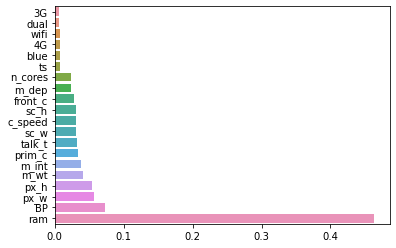

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
sorted_i = rf.feature_importances_.argsort()
sns.barplot(x=rf.feature_importances_[sorted_i], y=data.columns[sorted_i])
plt.show()

In [9]:
#1. 하위 6개 제거

data.drop(['3G', 'blue', 'dual', 'wifi', '4G', 'ts'], inplace=True, axis=1)

In [10]:
#Standardsacler

from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
X_scaled_standard = standard.fit_transform(X_data)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_standard, y_data, test_size=0.2, random_state=30)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8233
GaussianNB():  0.8167
RandomForestClassifier():  0.8533
AdaBoostClassifier():  0.7233
GradientBoostingClassifier():  0.8967
[15:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

In [13]:
#이상치 제거

#-1. IQR로 아웃라이어 제거 (성윤 캐글 참고)

def hello_outlier(df=None, column=None, weight=1.5) :
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

def bye_outlier(df=None, column=None, weight=1.5) :
    outlier_idx = hello_outlier(df=df, column=column, weight=1.5)
    df.drop(outlier_idx, axis=0, inplace=True)

In [14]:
for i in data.columns :
    print('칼럼이름 : ',i)
    print(hello_outlier(df=data, column=i, weight=1.5))

칼럼이름 :  BP
Int64Index([], dtype='int64')
칼럼이름 :  c_speed
Int64Index([], dtype='int64')
칼럼이름 :  front_c
Int64Index([95, 169, 226, 229, 300, 305, 372, 584, 1387, 1406, 1416], dtype='int64')
칼럼이름 :  m_int
Int64Index([], dtype='int64')
칼럼이름 :  m_dep
Int64Index([], dtype='int64')
칼럼이름 :  m_wt
Int64Index([], dtype='int64')
칼럼이름 :  n_cores
Int64Index([], dtype='int64')
칼럼이름 :  prim_c
Int64Index([], dtype='int64')
칼럼이름 :  px_h
Int64Index([], dtype='int64')
칼럼이름 :  px_w
Int64Index([], dtype='int64')
칼럼이름 :  ram
Int64Index([], dtype='int64')
칼럼이름 :  sc_h
Int64Index([], dtype='int64')
칼럼이름 :  sc_w
Int64Index([], dtype='int64')
칼럼이름 :  talk_t
Int64Index([], dtype='int64')
칼럼이름 :  target
Int64Index([], dtype='int64')


In [15]:
bye_outlier(df=data, column='front_c',weight=1.5)

In [16]:
X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

In [17]:
# Standardscaler

from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
X_scaled_standard = standard.fit_transform(X_data)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_standard, y_data, test_size=0.2, random_state=30)

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8389
GaussianNB():  0.7919
RandomForestClassifier():  0.8758
AdaBoostClassifier():  0.7383
GradientBoostingClassifier():  0.8960
[15:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

In [20]:
data = pd.read_csv('Electronics_train.csv')
data = data = data.iloc[:,1:]
data.drop(['3G', 'blue', 'dual', 'wifi', '4G', 'ts'], inplace=True, axis=1)

In [21]:
#-2 z score(표준화 후 이상치 제거)

X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

In [22]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_data.columns)

In [23]:
X_scaled_df.head()

,BP,c_speed,front_c,m_int,m_dep,m_wt,n_cores,prim_c,px_h,px_w,ram,sc_h,sc_w,talk_t
0,-0.908428,0.832539,-0.759235,-1.408691,0.350508,1.336082,-1.090027,-1.296378,-1.418046,-1.150394,0.384162,-0.793792,0.287837,1.460049
1,-0.500831,-1.252078,-0.989167,1.125718,0.700550,-0.141340,-0.654365,-0.637705,0.576155,1.724027,0.458924,1.110167,-0.636199,-0.763752
2,-1.543732,-1.252078,-0.529303,0.464568,1.400633,0.114368,0.216960,-0.637705,1.382849,1.089415,0.433395,-0.317802,-0.867208,-0.393119
3,-1.425324,1.200412,-0.989167,-1.243403,1.050591,-0.283400,0.652622,-0.143700,1.276942,1.252734,0.584743,0.872172,0.518846,-0.022485
4,1.320830,-0.393706,1.999947,0.629856,0.350508,0.000720,-1.090027,0.679641,1.258915,-0.086485,-0.653392,-1.031787,-0.867208,0.718782


In [24]:
scaled_data = pd.concat([X_scaled_df, y_data], axis=1)

In [25]:
#이상치 확인 
 
from scipy import stats

for i in scaled_data.columns:
    z_score = stats.zscore(scaled_data[i])
    print(i)
    print(scaled_data[~z_score.between(-3,3)].index,'\n')

BP
Int64Index([], dtype='int64') 

c_speed
Int64Index([], dtype='int64') 

front_c
Int64Index([95, 226, 305, 1387, 1406, 1416], dtype='int64') 

m_int
Int64Index([], dtype='int64') 

m_dep
Int64Index([], dtype='int64') 

m_wt
Int64Index([], dtype='int64') 

n_cores
Int64Index([], dtype='int64') 

prim_c
Int64Index([], dtype='int64') 

px_h
Int64Index([], dtype='int64') 

px_w
Int64Index([], dtype='int64') 

ram
Int64Index([], dtype='int64') 

sc_h
Int64Index([], dtype='int64') 

sc_w
Int64Index([], dtype='int64') 

talk_t
Int64Index([], dtype='int64') 

target
Int64Index([], dtype='int64') 



In [26]:
#이상치 제거

z_score = stats.zscore(scaled_data['front_c'])
standard_data = scaled_data[z_score.between(-3,3)]

In [27]:
X_data = standard_data.iloc[:,:-1]
y_data = standard_data.iloc[:,-1]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=30)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8161
GaussianNB():  0.8194
RandomForestClassifier():  0.8829
AdaBoostClassifier():  0.7324
GradientBoostingClassifier():  0.9130
[15:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

Light GBM 최대 : 92.3%

In [30]:
#LGBM, XGBM, RF feture importance 중 상위 10개 중복 feature 선택(성윤 캐글 참고)

sel_data = data[['BP', 'c_speed','m_int', 'm_wt', 'px_h', 'px_w', 'ram', 'talk_t', 'target']]

In [31]:
X_data = sel_data.iloc[:,:-1]
y_data = sel_data.iloc[:,-1]

In [32]:
# Standardscaler

from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
X_scaled_standard = standard.fit_transform(X_data)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_standard, y_data, test_size=0.2, random_state=30)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8200
GaussianNB():  0.7933
RandomForestClassifier():  0.8967
AdaBoostClassifier():  0.7233
GradientBoostingClassifier():  0.9000
[15:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

In [35]:
sel_data = data[['BP', 'm_wt', 'px_h', 'px_w', 'ram', 'target']]

In [36]:
X_data = sel_data.iloc[:,:-1]
y_data = sel_data.iloc[:,-1]

In [37]:
# Standardscaler

from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
X_scaled_standard = standard.fit_transform(X_data)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_standard, y_data, test_size=0.2, random_state=30)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8267
GaussianNB():  0.7933
RandomForestClassifier():  0.9233
AdaBoostClassifier():  0.7167
GradientBoostingClassifier():  0.9033
[15:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

In [45]:
model = xgb
model.fit(X_train, y_train)
pred_model = model.predict(X_test)
accuracy = accuracy_score(y_test, pred_model)

print('{0}: {1: .4f}'.format(model, accuracy))

[15:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None):  0.92

In [78]:
df = pd.read_csv('Electronics_train.csv')

In [79]:
df.drop(['dual','4G','3G','ts','wifi','blue'], inplace = True, axis=1)
bye_outlier(df=df, column='front_c',weight=1.5)

In [83]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

ss = StandardScaler()
scaled_X_standard = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X_standard, y, test_size=0.2)

In [84]:
model = xgb
model.fit(X_train, y_train)
pred_model = model.predict(X_test)
accuracy = accuracy_score(y_test, pred_model)

print('{0}: {1: .4f}'.format(model, accuracy))

[16:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None):  0.93

In [121]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(accuracy_score(y_test, preds))

[16:45:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9328859060402684


In [119]:
from sklearn.ensemble import VotingClassifier

voting_s = VotingClassifier(estimators=[('RF',rf), ('XGB',xgb),('LGBM',lgbm),('GB',gb),('LR',lr),('KNN',knn)], voting='soft')

voting_s.fit(X_train, y_train)
pred_s = voting_s.predict(X_test)

[16:40:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [120]:
accuracy_score(y_test, pred_s)

0.9295302013422819

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression()
knn = KNeighborsClassifier()

In [116]:
voting_s = VotingClassifier(estimators=[('RF',rf), ('LR',lr),('KNN',knn)], voting='soft')

voting_s.fit(X_train, y_train)
pred_s = voting_s.predict(X_test)

accuracy_score(y_test, pred_s)

0.9261744966442953

In [135]:
data = pd.read_csv('Electronics_train.csv')

In [136]:
sel_data = data[['BP', 'c_speed','m_int', 'm_wt', 'px_h', 'px_w', 'ram', 'talk_t', 'target']]

In [137]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

ss = StandardScaler()
scaled_X_standard = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X_standard, y, test_size=0.2)

In [138]:
model = xgb
model.fit(X_train, y_train)
pred_model = model.predict(X_test)
accuracy = accuracy_score(y_test, pred_model)

print('{0}: {1: .4f}'.format(model, accuracy))

[16:55:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None):  0.92

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

DecisionTreeClassifier():  0.8523
GaussianNB():  0.7852
RandomForestClassifier():  0.9128
AdaBoostClassifier():  0.7383
GradientBoostingClassifier():  0.9060
[16:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0,

In [143]:
voting_s = VotingClassifier(estimators=[('RF',rf), ('XGB',xgb),('LGBM',lgbm)], voting='soft')

voting_s.fit(X_train, y_train)
pred_s = voting_s.predict(X_test)

accuracy_score(y_test, pred_s)

[16:57:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9261744966442953